In [1]:
import ehrapy as ep
import seaborn as sns
import numpy as np
import pandas as pd
import re
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from dowhy import CausalModel
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import graphviz
import networkx as nx 

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


## Filter data to only the top X with the highest correlation

In [2]:
adata_df = pd.read_csv("./adata_pneumonia_drugcats_added.csv", sep=";")
adata_df.columns = adata_df.columns.str.replace(" ", "_")

# death_top100 = adata_df.corr()["Asparate_Aminotransferase_(AST)_max"].sort_values(ascending=False).head(100)
# death_top100[death_top100.index.str.contains("ALT")] # Alanine Aminotransferase (ALT)_max 
# death_top100[death_top100.index.str.contains("AST")] # Asparate Aminotransferase (AST)_max

# columns_to_retain = adata_df.columns[adata_df.columns.str.contains("LOS|drugcat")]
# adata_df = adata_df[columns_to_retain]

columns_to_retain = adata_df.columns[~adata_df.columns.str.contains("_0.0|_min|_avg|_Death_|ehrapycat|missing|leiden")]
adata_df = adata_df[columns_to_retain]

death_top100 = adata_df.corr()["LOS"].sort_values(ascending=False).head(150)
adata_df = adata_df[death_top100.index]
adata_df = adata_df.astype(float)

In [11]:
subset_df = adata_df[adata_df.columns[adata_df.columns.str.contains('drugcat')]]

# Add the 'LOS' column to the subset
subset_df = pd.concat([subset_df, adata_df['LOS']], axis=1)

# Calculate the correlation
correlation = subset_df.corr()['LOS'].drop('LOS')
correlation

drugcat_Cytochrome_P-450_CYP2C9_Inhibitors    0.097658
Name: LOS, dtype: float64

In [4]:
adata_df

,LOS,Base_Excess_max,"Calculated_Bicarbonate,_Whole_Blood_max",Bicarbonate_max,Carboxyhemoglobin_max,Eosinophils_max,pCO2_max,sputum_positive_bacteria,pH_max,Lactobacillus_LB_sachets,...,received_antivirals,Recombinant_Human_Granulocyte_Colony-stimulating_Factor_Injection,Lactate_max,Oseltamivir__Phosphate_Capsules,Ribavirin_for_Injection,Lidocaine_Hydrochloride_Injection,Salbutamol_Sulfate_Nebules_Inhalation_Solution,sputum_positive_fungi,Fat-Soluble_Vitamin_Injection(Ⅱ),Adrenaline_Hydrochlaride_Injection
0,41.0,20.940,36.74,35.125,2.470,4.815,75.350,0.0,7.55040,4.5,...,0.0,0.0,4.070,0.0,0.0,5.0,23.0,0.0,50.0,6.10
1,14.0,17.080,32.41,31.710,2.025,3.290,61.505,0.0,7.52155,0.0,...,1.0,0.0,3.390,50.0,0.0,0.0,0.0,0.0,0.0,0.00
2,12.0,15.015,30.30,29.775,2.030,2.345,54.175,0.0,7.50860,0.0,...,1.0,0.0,3.025,0.0,0.0,0.0,0.5,0.0,50.0,0.52
3,0.0,8.350,24.12,23.535,1.445,1.950,49.415,0.0,7.37775,0.0,...,0.0,0.0,3.410,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,33.0,19.275,34.93,33.610,2.495,4.485,72.235,0.0,7.54580,0.0,...,1.0,0.0,3.980,60.0,0.0,0.0,2.0,0.0,0.0,13.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,3.0,9.300,24.20,24.900,2.000,0.700,37.700,0.0,7.46600,0.0,...,0.0,0.0,2.000,0.0,0.0,0.0,0.0,1.0,0.0,0.00
273,33.0,12.800,26.70,28.700,2.700,4.000,55.100,1.0,7.58000,0.0,...,0.0,0.0,4.400,0.0,0.0,10.0,0.0,0.0,0.0,0.00
274,1.0,11.900,26.30,27.300,1.200,0.000,47.000,0.0,7.49600,0.0,...,0.0,0.0,4.100,0.0,0.0,0.0,22.5,0.0,0.0,4.45
275,1.0,8.900,22.20,25.000,1.600,0.100,25.500,0.0,7.54900,0.0,...,0.0,0.0,1.400,0.0,0.0,0.0,0.0,0.0,0.0,0.00


## Run the cdt toolbox to generate the adjacency matrix

In [5]:
adata_df

def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.1
    dirs = np.where(idx)
    nx_graph = nx.DiGraph()
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]

    for name in names:
        nx_graph.add_node(name)
    
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        nx_graph.add_edge(names[from_], names[to], label=np.round(coef, 3))
        
    adjacency_matrix = pd.DataFrame(adjacency_matrix, index=names, columns=names)
    cycles = list(nx.simple_cycles(nx_graph))

    for cycle in cycles:
        lowest_weight = float('inf')
        bad_u = None
        bad_v = None
        # find lowest weight per cycle
        for u, v in zip(cycle, cycle[1:] + [cycle[0]]):
            weight = adjacency_matrix[u][v]
            if weight < lowest_weight:
                lowest_weight = weight
                bad_u = u
                bad_v = v
        # remove edge with lowest weight
        adjacency_matrix[bad_u][bad_v] = 0

    d = graphviz.Digraph(engine='dot')
    
    # Add nodes
    for column in adjacency_matrix.columns:
        d.node(column)
    
    # Add edges
    for from_node in adjacency_matrix.columns:
        for to_node in adjacency_matrix.columns:
            if adjacency_matrix.loc[from_node, to_node] != 0:
                weight = str(np.round(adjacency_matrix.loc[from_node, to_node],3))
                d.edge(from_node, to_node, label=weight)

    return d
        

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

from cdt.causality.graph import LiNGAM, PC, GES

adj_matrices = {}
graphs = {}
labels = [f'{col}' for i, col in enumerate(adata_df.columns)]
# functions = {
#     # 'LiNGAM' : LiNGAM,
#     # 'PC' : PC, #  doc says < 200 variables but works
#     'GES' : GES, # bad?
# }

obj = PC()


output = obj.predict(adata_df)
adj_matrix = nx.to_numpy_matrix(output)
adj_matrix = np.asarray(adj_matrix)
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] == 1:
            # Replace the value with the correlation coefficient
            adj_matrix[i, j] = adata_df.corr().iloc[i, j]
graph_dot = make_graph(adj_matrix, labels)
adj_matrix = adj_matrix
graph = graph_dot



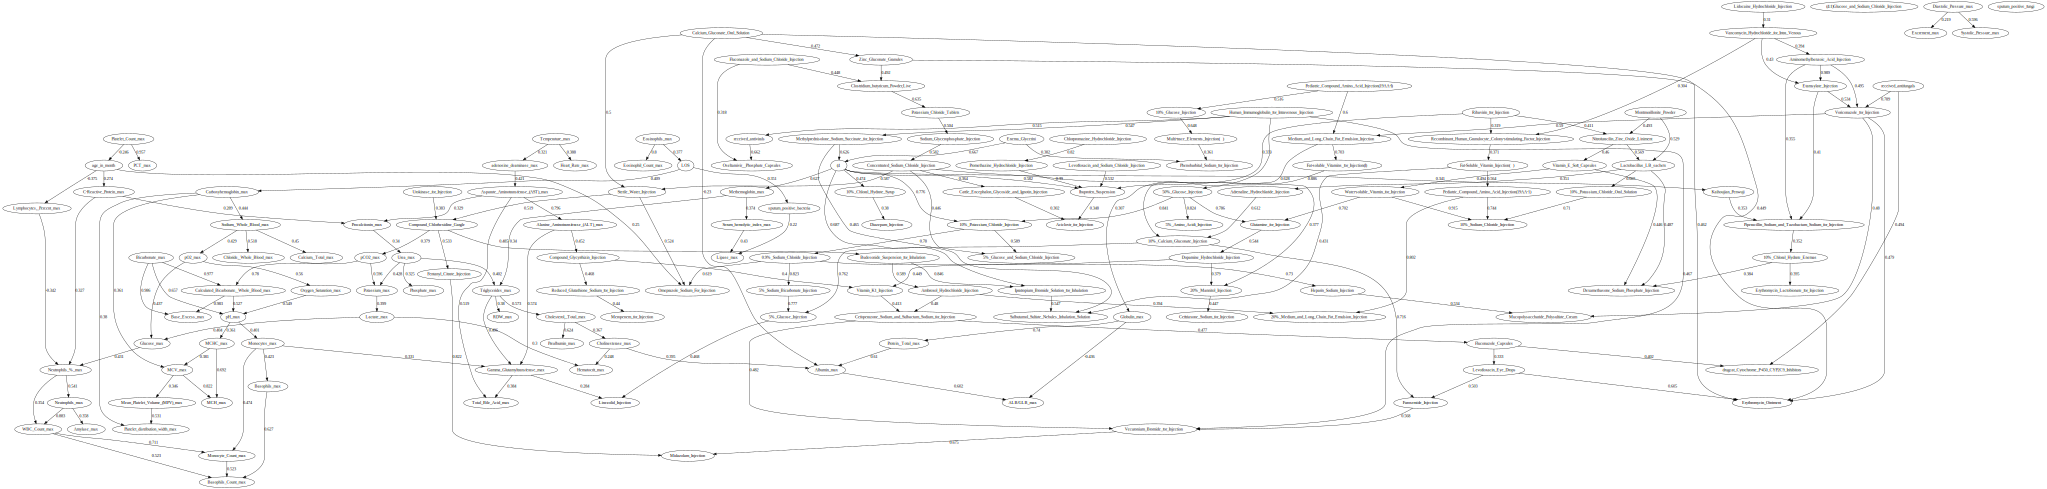

In [6]:
display(graph)


In [7]:
graph = graph.source
graph = graph.strip().replace('\n', ';').replace('\t','')
graph = graph[:9] + graph[10:-2] + graph[-1]

In [8]:
for idx, col in tqdm(enumerate(adata_df.columns), total=len(adata_df.columns)):
    try:
        
        # Define Causal Model
        model=CausalModel(
            data = adata_df, 
            treatment=col, 
            outcome="LOS", 
            graph=graph,
        )
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.linear_regression",
        )
        val = estimate.value # / np.median(adata_df[col])
        if estimate.value is not None and estimate.value > 0:
            print(idx, "Causal Estimate is " + str(val), col)
        model.refute_estimate(
            identified_estimand,
            estimate,
            method_name="random_common_cause"
        )
        
    except:
        pass

  0%|          | 0/150 [00:00<?, ?it/s]

  3%|▎         | 5/150 [00:02<01:08,  2.11it/s]

5 Causal Estimate is 3.35161722931767 Eosinophils_max


100%|██████████| 150/150 [01:08<00:00,  2.20it/s]


In [12]:
import anndata

e = ep.tl.causal_inference(
    adata=anndata.AnnData(adata_df), 
    graph=graph,
    treatment="drugcat_Cytochrome_P-450_CYP2C9_Inhibitors", 
    outcome="LOS", 
    estimation_method="backdoor.linear_regression",
        refute_methods = [
        "placebo_treatment_refuter",
        "random_common_cause",
        "data_subset_refuter",
        "add_unobserved_common_cause"
    ],
    print_causal_estimate=True,
    print_summary=True,
    show_graph=False,
    show_refute_plots="contour",
    return_as="estimate",
    identify_kwargs={"proceed_when_unidentifiable": True},
    attempts=5,
)
ep.tl.plot_causal_effect(e)

╭─────────────────────────────────────── Traceback (most recent call last) ───────────────────────────────────────╮
│ in <module>:3                                                                                                   │
│                                                                                                                 │
│    1 import anndata                                                                                             │
│    2                                                                                                            │
│ ❱  3 e = ep.tl.causal_inference(                                                                                │
│    4 │   adata=anndata.AnnData(adata_df),                                                                       │
│    5 │   graph=graph,                                                                                           │
│    6 │   treatment="drugcat_Cytochrome_P-450_CYP2C9_Inhibitors",                                                │
│                                                                                                                 │
│ /Users/tim.treis/Documents/GitHub/ehrapy/ehrapy/tools/causal/_dowhy.py:218 in causal_inference                  │
│                                                                                                                 │
│   215 │   │   for method in refute_methods:                                                                     │
│   216 │   │   │   try:                                                                                          │
│   217 │   │   │   │   with capture_output() as _:                                                               │
│ ❱ 218 │   │   │   │   │   refute = model.refute_estimate(                                                       │
│   219 │   │   │   │   │   │   identified_estimand, estimate, method_name=method,                                │
│       verbose=False, **refute_kwargs                                                                            │
│   220 │   │   │   │   │   )                                                                                     │
│   221 │   │   │   │   │   refute_failed = False                                                                 │
│                                                                                                                 │
│ /Users/tim.treis/anaconda3/envs/ehrapy/lib/python3.10/site-packages/dowhy/causal_model.py:416 in                │
│ refute_estimate                                                                                                 │
│                                                                                                                 │
│   413 │   │   else:                                                                                             │
│   414 │   │   │   refuter_class = causal_refuters.get_class_object(method_name)                                 │
│   415 │   │                                                                                                     │
│ ❱ 416 │   │   refuter = refuter_class(self._data, identified_estimand=estimand,                                 │
│       estimate=estimate, **kwargs)                                                                              │
│   417 │   │   res = refuter.refute_estimate(show_progress_bar)                                                  │
│   418 │   │   return res                                                                                        │
│   419                                                                                                           │
│                                                                                                                 │
│ /Users/tim.treis/anaconda3/envs/ehrapy/lib/python3.10/site-packages/dowhy/causal_refuters/placebo_treatment_ref │
│ uter.py:58 in __init__                                